# lib

In [1]:
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from itertools import product
# import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [2]:
# !pip install pandas_ta
import pandas_ta as ta

# preprocessing data

In [3]:
path_to_file = "btch.csv"

date
2018-05-15 06:00:00     8740.99
2018-05-15 07:00:00     8739.00
2018-05-15 08:00:00     8728.49
2018-05-15 09:00:00     8708.32
2018-05-15 10:00:00     8795.90
                         ...   
2022-05-13 20:00:00    29747.79
2022-05-13 21:00:00    30000.35
2022-05-13 22:00:00    29763.22
2022-05-13 23:00:00    29238.81
2022-05-14 00:00:00    29397.44
Name: close, Length: 35035, dtype: float64

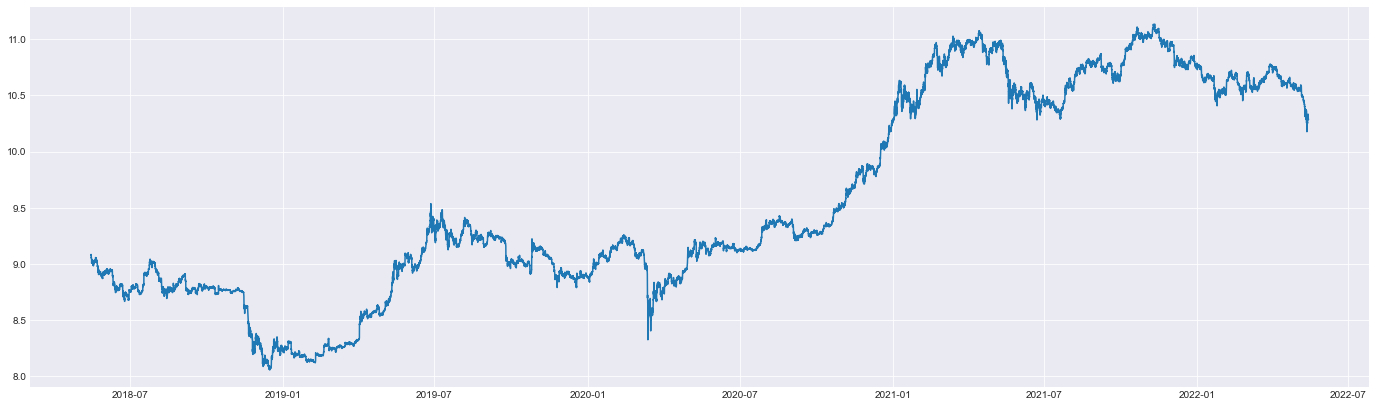

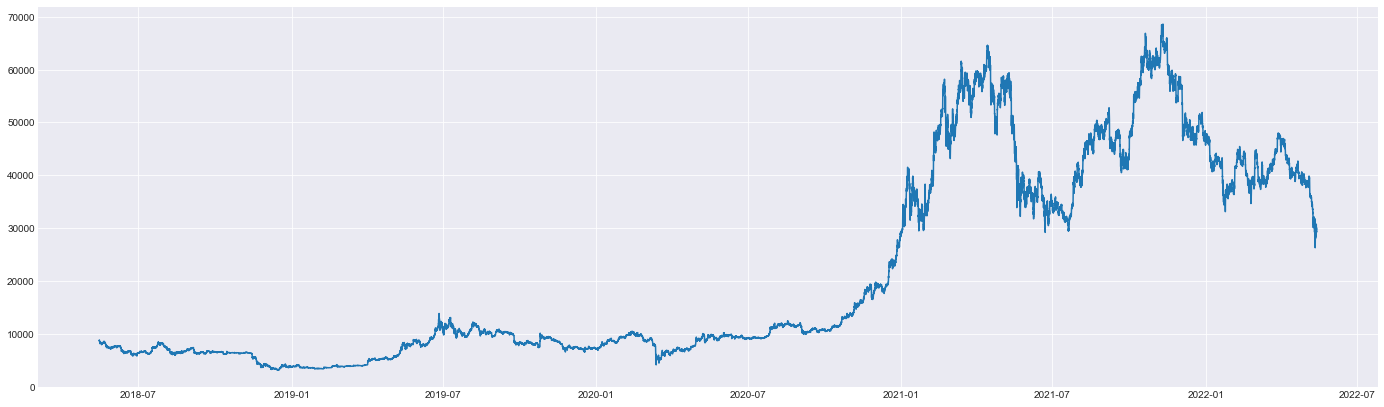

In [59]:
btc_input_df = pd.read_csv(path_to_file,skiprows=1)[::-1].reset_index()
btc_input_df = btc_input_df.astype({'date' : 'datetime64'})
index = btc_input_df.date
btc_input_df = btc_input_df.set_index('date').drop(['unix','symbol'], axis=1)['close']

plt.figure(figsize=(24,7))
plt.plot(np.log(btc_input_df))
plt.figure(figsize=(24,7))
plt.plot(btc_input_df)
btc_input_df

In [64]:
btc = pd.DataFrame()

btc['close_log'] = np.log(btc_input_df)
btc['target_log'] = btc['close_log'].shift(-1)

btc = btc.set_index(index).dropna()
btc.head(2)

,close_log,target_log
date,,
2018-05-15 06:00:00,9.075779,9.075551
2018-05-15 07:00:00,9.075551,9.074348


In [65]:
with open('btcH.moh','wb') as f :
    pickle.dump(btc,f)

# Load data

In [66]:
with open('btcH.moh','rb') as f :
    btc = pickle.load(f)

In [67]:
btc.head(2)

,close_log,target_log
date,,
2018-05-15 06:00:00,9.075779,9.075551
2018-05-15 07:00:00,9.075551,9.074348


In [68]:
btc.columns 

Index(['close_log', 'target_log'], dtype='object')

In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))


btc.close_log = scaler.fit_transform(btc.close_log.values.reshape(-1,1))
btc.target_log = scaler.transform(btc.target_log.values.reshape(-1,1))



In [72]:
btc.head(2)

,close_log,target_log
date,,
2018-05-15 06:00:00,0.331938,0.331865
2018-05-15 07:00:00,0.331865,0.331474


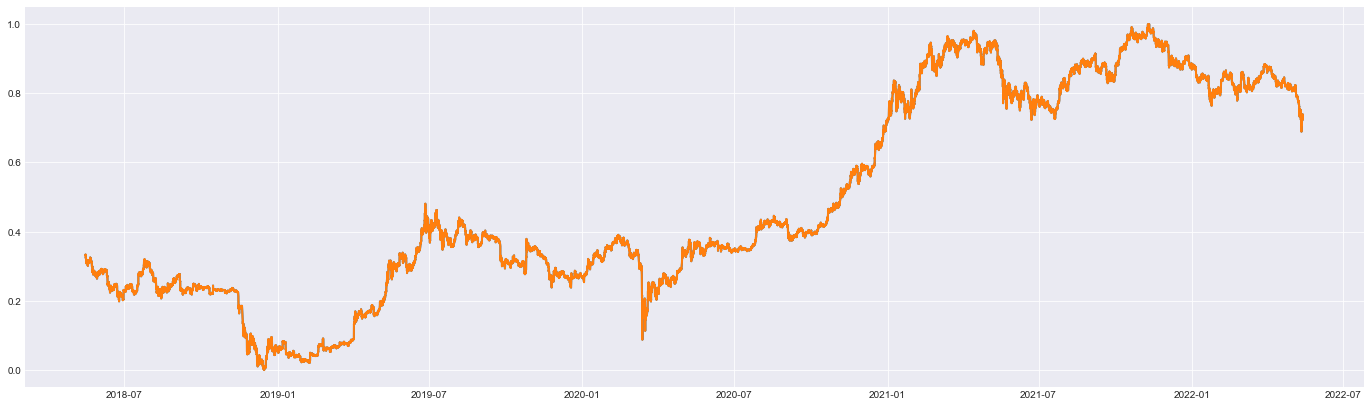

In [74]:

fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(btc, label='close', linewidth=2)



In [76]:
with open('btc_stanH.moh','wb') as f :
    pickle.dump(btc,f)

# creat data lstm

In [88]:
# from google.colab import drive
# drive.mount('/content/drive')
with open('btc_stanH.moh','rb') as f :
    btc = pickle.load(f)

In [89]:
look_back_ = 168
prediction_days = 48
future_ = 48

look_b = btc[:][:len(btc)-(future_)]

df_train_= btc[:][:len(btc)-(prediction_days+future_)]#values.reshape(-1,1)

df_test_= btc[:][len(btc)-(prediction_days+future_+look_back_-1):len(btc)-future_]#.values.reshape(-1,1)

future_ = btc[:][len(btc)-(future_+look_back_-1):]


In [90]:
df_train_.columns

Index(['close_log', 'target_log'], dtype='object')

In [91]:
col = df_train_.columns
df_train = df_train_[:][col]
df_test = df_test_[:][col]
future = future_[:][col]
df_test.head(2)

,close_log,target_log
date,,
2022-05-03 01:00:00,0.812719,0.811759
2022-05-03 02:00:00,0.811759,0.812630


In [92]:
# many to one

from collections import deque
def dataset_generator_lstm(dataset, look_back=look_back_):
    sequential_data = [] 
    prev_days = deque(maxlen=look_back)
    for i in dataset.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == look_back:  
            sequential_data.append([np.array(prev_days), i[-1]])
    dataX=[]
    dataY=[]
    for seq, target in sequential_data: 
        dataX.append(seq) 
        dataY.append(target) 
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(df_train)

testX, testY = dataset_generator_lstm(df_test)

futureX, futureY = dataset_generator_lstm(future)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)
print("futureX: ", futureX.shape)
print("futureY", futureY.shape)

trainX:  (34771, 168, 1)
trainY:  (34771,)
testX:  (48, 168, 1)
testY (48,)
futureX:  (48, 168, 1)
futureY (48,)


# train

In [93]:
regressor = Sequential()

# regressor.add(LSTM(units = 1024, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 4096, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.35))

regressor.add(LSTM(units = 1024, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.25))

regressor.add(LSTM(units = 2048, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 1024, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.25))

regressor.add(LSTM(units = 512, activation = 'relu', input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = look_back_, activation = 'relu'))
regressor.add(Dropout(0.15))

regressor.add(Dense(units = 1))

regressor.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 4096)         67141632  
                                                                 
 dropout (Dropout)           (None, 168, 4096)         0         
                                                                 
 lstm_1 (LSTM)               (None, 168, 1024)         20975616  
                                                                 
 dropout_1 (Dropout)         (None, 168, 1024)         0         
                                                                 
 lstm_2 (LSTM)               (None, 168, 2048)         25174016  
                                                                 
 dropout_2 (Dropout)         (None, 168, 2048)         0         
                                                                 
 lstm_3 (LSTM)               (None, 168, 1024)         1

In [23]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

batch_size = 1024

earlystopping = EarlyStopping(monitor='loss', patience=200, restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='loss', patience=30, factor=0.5, min_lr=0.000001)
checkpoint_full = ModelCheckpoint(filepath='my_best_model_v09.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks = [checkpoint_full, earlystopping, rlrop]

history_full = model.fit(trainX, trainY, batch_size = batch_size, epochs = 10000000, verbose=1, shuffle=False, validation_data=(testX_log, testY_log), callbacks=callbacks)


Epoch 1/50000
14/14 [==============================] - ETA: 0s - loss: 8.5108 
Epoch 1: loss improved from inf to 8.51079, saving model to my_best_model_full.hdf5
14/14 [==============================] - 410s 29s/step - loss: 8.5108 - val_loss: 2.5318
Epoch 2/50000
14/14 [==============================] - ETA: 0s - loss: 193096.2500
Epoch 2: loss did not improve from 8.51079
14/14 [==============================] - 381s 27s/step - loss: 193096.2500 - val_loss: 11972.9482
Epoch 3/50000
14/14 [==============================] - ETA: 0s - loss: 567390.6875
Epoch 3: loss did not improve from 8.51079
14/14 [==============================] - 380s 27s/step - loss: 567390.6875 - val_loss: 192.0229
Epoch 4/50000
14/14 [==============================] - ETA: 0s - loss: 728336448.0000
Epoch 4: loss did not improve from 8.51079
14/14 [==============================] - 379s 27s/step - loss: 728336448.0000 - val_loss: 432777344.0000
Epoch 5/50000
14/14 [==============================] - ETA: 0s - los

Epoch 37/50000
14/14 [==============================] - ETA: 0s - loss: 0.8623 
Epoch 37: loss did not improve from 0.85069
14/14 [==============================] - 372s 26s/step - loss: 0.8623 - val_loss: 2.5129
Epoch 38/50000
14/14 [==============================] - ETA: 0s - loss: 1.1702 
Epoch 38: loss did not improve from 0.85069
14/14 [==============================] - 371s 26s/step - loss: 1.1702 - val_loss: 2.5129
Epoch 39/50000
14/14 [==============================] - ETA: 0s - loss: 0.9440 
Epoch 39: loss did not improve from 0.85069
14/14 [==============================] - 372s 26s/step - loss: 0.9440 - val_loss: 2.5129
Epoch 40/50000
14/14 [==============================] - ETA: 0s - loss: 0.8521 
Epoch 40: loss did not improve from 0.85069
14/14 [==============================] - 371s 26s/step - loss: 0.8521 - val_loss: 2.5129
Epoch 41/50000
14/14 [==============================] - ETA: 0s - loss: 0.8521 
Epoch 41: loss did not improve from 0.85069
14/14 [=================

14/14 [==============================] - 368s 26s/step - loss: 0.8521 - val_loss: 2.5130
Epoch 76/50000
14/14 [==============================] - ETA: 0s - loss: 0.8521 
Epoch 76: loss did not improve from 0.85069
14/14 [==============================] - 369s 26s/step - loss: 0.8521 - val_loss: 2.5130
Epoch 77/50000
14/14 [==============================] - ETA: 0s - loss: 0.8521 
Epoch 77: loss did not improve from 0.85069
14/14 [==============================] - 369s 26s/step - loss: 0.8521 - val_loss: 2.5130
Epoch 78/50000
14/14 [==============================] - ETA: 0s - loss: 0.8521 
Epoch 78: loss did not improve from 0.85069
14/14 [==============================] - 370s 26s/step - loss: 0.8521 - val_loss: 2.5130
Epoch 79/50000
14/14 [==============================] - ETA: 0s - loss: 0.8521 
Epoch 79: loss did not improve from 0.85069
14/14 [==============================] - 368s 26s/step - loss: 0.8521 - val_loss: 2.5130
Epoch 80/50000
14/14 [==============================] - ETA

Epoch 114/50000
14/14 [==============================] - ETA: 0s - loss: 0.8477 
Epoch 114: loss improved from 0.85069 to 0.84767, saving model to my_best_model_full.hdf5
14/14 [==============================] - 374s 27s/step - loss: 0.8477 - val_loss: 2.5138
Epoch 115/50000
14/14 [==============================] - ETA: 0s - loss: 0.8380 
Epoch 115: loss improved from 0.84767 to 0.83805, saving model to my_best_model_full.hdf5
14/14 [==============================] - 374s 27s/step - loss: 0.8380 - val_loss: 2.5131
Epoch 116/50000
14/14 [==============================] - ETA: 0s - loss: 0.8427 
Epoch 116: loss did not improve from 0.83805
14/14 [==============================] - 371s 26s/step - loss: 0.8427 - val_loss: 2.5131
Epoch 117/50000
14/14 [==============================] - ETA: 0s - loss: 0.8453 
Epoch 117: loss did not improve from 0.83805
14/14 [==============================] - 370s 26s/step - loss: 0.8453 - val_loss: 2.5131
Epoch 118/50000
14/14 [===========================

Epoch 150/50000
14/14 [==============================] - ETA: 0s - loss: 27024.9238 
Epoch 150: loss did not improve from 0.45782
14/14 [==============================] - 368s 26s/step - loss: 27024.9238 - val_loss: 2.4981
Epoch 151/50000
14/14 [==============================] - ETA: 0s - loss: 205823056.0000
Epoch 151: loss did not improve from 0.45782
14/14 [==============================] - 370s 26s/step - loss: 205823056.0000 - val_loss: 2.4951
Epoch 152/50000
14/14 [==============================] - ETA: 0s - loss: 309917.3125 
Epoch 152: loss did not improve from 0.45782
14/14 [==============================] - 370s 26s/step - loss: 309917.3125 - val_loss: 473.3143
Epoch 153/50000
14/14 [==============================] - ETA: 0s - loss: 9609.2314  
Epoch 153: loss did not improve from 0.45782
14/14 [==============================] - 370s 26s/step - loss: 9609.2314 - val_loss: 8.6546
Epoch 154/50000
14/14 [==============================] - ETA: 0s - loss: 871564.8750 
Epoch 154: l

14/14 [==============================] - ETA: 0s - loss: 0.9489 
Epoch 225: loss did not improve from 0.45782
14/14 [==============================] - 371s 26s/step - loss: 0.9489 - val_loss: 2.6139
Epoch 226/50000
14/14 [==============================] - ETA: 0s - loss: 0.8494 
Epoch 226: loss did not improve from 0.45782
14/14 [==============================] - 369s 26s/step - loss: 0.8494 - val_loss: 2.6139
Epoch 227/50000
14/14 [==============================] - ETA: 0s - loss: 0.8490 
Epoch 227: loss did not improve from 0.45782
14/14 [==============================] - 369s 26s/step - loss: 0.8490 - val_loss: 2.6139
Epoch 228/50000
14/14 [==============================] - ETA: 0s - loss: 0.8673 
Epoch 228: loss did not improve from 0.45782
14/14 [==============================] - 369s 26s/step - loss: 0.8673 - val_loss: 2.6139
Epoch 229/50000
14/14 [==============================] - ETA: 0s - loss: 0.8612 
Epoch 229: loss did not improve from 0.45782
14/14 [=======================

14/14 [==============================] - ETA: 0s - loss: 0.8493 
Epoch 301: loss did not improve from 0.45782
14/14 [==============================] - 372s 26s/step - loss: 0.8493 - val_loss: 2.6254
Epoch 302/50000
14/14 [==============================] - ETA: 0s - loss: 0.8493 
Epoch 302: loss did not improve from 0.45782
14/14 [==============================] - 369s 26s/step - loss: 0.8493 - val_loss: 2.6254
Epoch 303/50000
14/14 [==============================] - ETA: 0s - loss: 0.8493 
Epoch 303: loss did not improve from 0.45782
14/14 [==============================] - 370s 26s/step - loss: 0.8493 - val_loss: 2.6254
Epoch 304/50000
14/14 [==============================] - ETA: 0s - loss: 0.8493 
Epoch 304: loss did not improve from 0.45782
14/14 [==============================] - 369s 26s/step - loss: 0.8493 - val_loss: 2.6254
Epoch 305/50000
14/14 [==============================] - ETA: 0s - loss: 0.8493 
Epoch 305: loss did not improve from 0.45782
14/14 [=======================

Epoch 378/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 378: loss did not improve from 0.45782
14/14 [==============================] - 372s 27s/step - loss: nan - val_loss: nan
Epoch 379/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 379: loss did not improve from 0.45782
14/14 [==============================] - 366s 26s/step - loss: nan - val_loss: nan
Epoch 380/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 380: loss did not improve from 0.45782
14/14 [==============================] - 377s 27s/step - loss: nan - val_loss: nan
Epoch 381/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 381: loss did not improve from 0.45782
14/14 [==============================] - 372s 26s/step - loss: nan - val_loss: nan
Epoch 382/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 382: loss did not improve from 0.45782
14/14 [==============================] - 360s 26s/ste

Epoch 418/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 418: loss did not improve from 0.45782
14/14 [==============================] - 373s 27s/step - loss: nan - val_loss: nan
Epoch 419/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 419: loss did not improve from 0.45782
14/14 [==============================] - 362s 26s/step - loss: nan - val_loss: nan
Epoch 420/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 420: loss did not improve from 0.45782
14/14 [==============================] - 370s 26s/step - loss: nan - val_loss: nan
Epoch 421/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 421: loss did not improve from 0.45782
14/14 [==============================] - 372s 26s/step - loss: nan - val_loss: nan
Epoch 422/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 422: loss did not improve from 0.45782
14/14 [==============================] - 366s 26s/ste

Epoch 458/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 458: loss did not improve from 0.45782
14/14 [==============================] - 370s 26s/step - loss: nan - val_loss: nan
Epoch 459/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 459: loss did not improve from 0.45782
14/14 [==============================] - 355s 25s/step - loss: nan - val_loss: nan
Epoch 460/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 460: loss did not improve from 0.45782
14/14 [==============================] - 370s 26s/step - loss: nan - val_loss: nan
Epoch 461/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 461: loss did not improve from 0.45782
14/14 [==============================] - 371s 26s/step - loss: nan - val_loss: nan
Epoch 462/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 462: loss did not improve from 0.45782
14/14 [==============================] - 366s 26s/ste

Epoch 498/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 498: loss did not improve from 0.45782
14/14 [==============================] - 371s 26s/step - loss: nan - val_loss: nan
Epoch 499/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 499: loss did not improve from 0.45782
14/14 [==============================] - 361s 26s/step - loss: nan - val_loss: nan
Epoch 500/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 500: loss did not improve from 0.45782
14/14 [==============================] - 372s 27s/step - loss: nan - val_loss: nan
Epoch 501/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 501: loss did not improve from 0.45782
14/14 [==============================] - 372s 27s/step - loss: nan - val_loss: nan
Epoch 502/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 502: loss did not improve from 0.45782
14/14 [==============================] - 356s 25s/ste

Epoch 538/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 538: loss did not improve from 0.45782
14/14 [==============================] - 370s 26s/step - loss: nan - val_loss: nan
Epoch 539/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 539: loss did not improve from 0.45782
14/14 [==============================] - 360s 26s/step - loss: nan - val_loss: nan
Epoch 540/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 540: loss did not improve from 0.45782
14/14 [==============================] - 372s 27s/step - loss: nan - val_loss: nan
Epoch 541/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 541: loss did not improve from 0.45782
14/14 [==============================] - 369s 26s/step - loss: nan - val_loss: nan
Epoch 542/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 542: loss did not improve from 0.45782
14/14 [==============================] - 360s 26s/ste

Epoch 578/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 578: loss did not improve from 0.45782
14/14 [==============================] - 372s 27s/step - loss: nan - val_loss: nan
Epoch 579/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 579: loss did not improve from 0.45782
14/14 [==============================] - 363s 26s/step - loss: nan - val_loss: nan
Epoch 580/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 580: loss did not improve from 0.45782
14/14 [==============================] - 372s 27s/step - loss: nan - val_loss: nan
Epoch 581/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 581: loss did not improve from 0.45782
14/14 [==============================] - 371s 26s/step - loss: nan - val_loss: nan
Epoch 582/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 582: loss did not improve from 0.45782
14/14 [==============================] - 359s 26s/ste

Epoch 618/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 618: loss did not improve from 0.45782
14/14 [==============================] - 371s 26s/step - loss: nan - val_loss: nan
Epoch 619/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 619: loss did not improve from 0.45782
14/14 [==============================] - 353s 25s/step - loss: nan - val_loss: nan
Epoch 620/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 620: loss did not improve from 0.45782
14/14 [==============================] - 372s 26s/step - loss: nan - val_loss: nan
Epoch 621/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 621: loss did not improve from 0.45782
14/14 [==============================] - 372s 27s/step - loss: nan - val_loss: nan
Epoch 622/50000
14/14 [==============================] - ETA: 0s - loss: nan 
Epoch 622: loss did not improve from 0.45782
14/14 [==============================] - 366s 26s/ste

Epoch 71/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 71: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 72/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 72: loss did not improve from inf
6/6 [==============================] - 147s 24s/step - loss: nan - val_loss: nan
Epoch 73/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 73: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 74/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 74: loss did not improve from inf
6/6 [==============================] - 150s 24s/step - loss: nan - val_loss: nan
Epoch 75/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 75: loss did not improve from inf
6/6 [==============================] - 153s 25s/step - loss: nan - val_loss: nan
Epoch 76/50000
6/6 [

Epoch 113/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 113: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 114/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 114: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 115/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 115: loss did not improve from inf
6/6 [==============================] - 142s 24s/step - loss: nan - val_loss: nan
Epoch 116/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 116: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 117/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 117: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 118/

6/6 [==============================] - 141s 23s/step - loss: nan - val_loss: nan
Epoch 196/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 196: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 197/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 197: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 198/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 198: loss did not improve from inf
6/6 [==============================] - 150s 24s/step - loss: nan - val_loss: nan
Epoch 199/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 199: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 200/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 200: loss did not improve from inf
6/6 [=====

Epoch 237/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 237: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 238/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 238: loss did not improve from inf
6/6 [==============================] - 139s 22s/step - loss: nan - val_loss: nan
Epoch 239/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 239: loss did not improve from inf
6/6 [==============================] - 150s 24s/step - loss: nan - val_loss: nan
Epoch 240/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 240: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 241/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 241: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 242/

6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 320/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 320: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 321/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 321: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 322/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 322: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 323/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 323: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 324/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 324: loss did not improve from inf
6/6 [=====

Epoch 361/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 361: loss did not improve from inf
6/6 [==============================] - 143s 23s/step - loss: nan - val_loss: nan
Epoch 362/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 362: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 363/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 363: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 364/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 364: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 365/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 365: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 366/

6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 444/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 444: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 445/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 445: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 446/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 446: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 447/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 447: loss did not improve from inf
6/6 [==============================] - 145s 24s/step - loss: nan - val_loss: nan
Epoch 448/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 448: loss did not improve from inf
6/6 [=====

Epoch 485/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 485: loss did not improve from inf
6/6 [==============================] - 148s 25s/step - loss: nan - val_loss: nan
Epoch 486/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 486: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 487/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 487: loss did not improve from inf
6/6 [==============================] - 150s 25s/step - loss: nan - val_loss: nan
Epoch 488/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 488: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 489/50000
6/6 [==============================] - ETA: 0s - loss: nan 
Epoch 489: loss did not improve from inf
6/6 [==============================] - 151s 25s/step - loss: nan - val_loss: nan
Epoch 490/

Epoch 27/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 27: loss did not improve from inf
3/3 [==============================] - 74s 22s/step - loss: nan - val_loss: nan
Epoch 28/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 28: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 29/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 29: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 30/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 30: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 31/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 31: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 32/50000
3/3 [=====

3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 69: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 70/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 70: loss did not improve from inf
3/3 [==============================] - 65s 19s/step - loss: nan - val_loss: nan
Epoch 71/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 71: loss did not improve from inf
3/3 [==============================] - 73s 23s/step - loss: nan - val_loss: nan
Epoch 72/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 72: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 73/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 73: loss did not improve from inf
3/3 [==============================] - 73s 22s/step - loss: nan - val_loss: nan
Epoch 74/50000
3/3 [====================

Epoch 111/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 111: loss did not improve from inf
3/3 [==============================] - 73s 23s/step - loss: nan - val_loss: nan
Epoch 112/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 112: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 113/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 113: loss did not improve from inf
3/3 [==============================] - 73s 23s/step - loss: nan - val_loss: nan
Epoch 114/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 114: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 115/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 115: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 116/50000

3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 153/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 153: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 154/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 154: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 155/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 155: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 156/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 156: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 157/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 157: loss did not improve from inf
3/3 [==========

Epoch 236/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 236: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 237/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 237: loss did not improve from inf
3/3 [==============================] - 64s 22s/step - loss: nan - val_loss: nan
Epoch 238/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 238: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 239/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 239: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 240/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 240: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 241/50000

3/3 [==============================] - 73s 22s/step - loss: nan - val_loss: nan
Epoch 278/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 278: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 279/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 279: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 280/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 280: loss did not improve from inf
3/3 [==============================] - 73s 23s/step - loss: nan - val_loss: nan
Epoch 281/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 281: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 282/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 282: loss did not improve from inf
3/3 [==========

Epoch 361/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 361: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 362/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 362: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 363/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 363: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 364/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 364: loss did not improve from inf
3/3 [==============================] - 73s 22s/step - loss: nan - val_loss: nan
Epoch 365/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 365: loss did not improve from inf
3/3 [==============================] - 65s 23s/step - loss: nan - val_loss: nan
Epoch 366/50000

3/3 [==============================] - 72s 23s/step - loss: nan - val_loss: nan
Epoch 403/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 403: loss did not improve from inf
3/3 [==============================] - 65s 21s/step - loss: nan - val_loss: nan
Epoch 404/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 404: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 405/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 405: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 406/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 406: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 407/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 407: loss did not improve from inf
3/3 [==========

Epoch 486/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 486: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 487/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 487: loss did not improve from inf
3/3 [==============================] - 72s 23s/step - loss: nan - val_loss: nan
Epoch 488/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 488: loss did not improve from inf
3/3 [==============================] - 72s 23s/step - loss: nan - val_loss: nan
Epoch 489/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 489: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 490/50000
3/3 [==============================] - ETA: 0s - loss: nan 
Epoch 490: loss did not improve from inf
3/3 [==============================] - 72s 22s/step - loss: nan - val_loss: nan
Epoch 491/50000

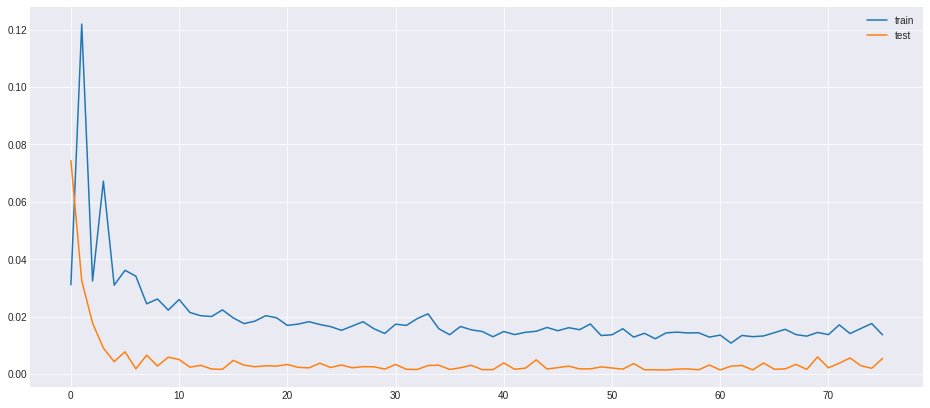

In [217]:
plt.figure(figsize=(16,7))
plt.plot(history_full.history['loss'], label='train')

plt.plot(history_full.history['val_loss'], label='test')
plt.legend()
plt.show()

In [279]:
from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model('my_best_model_v09.hdf5')

# test test

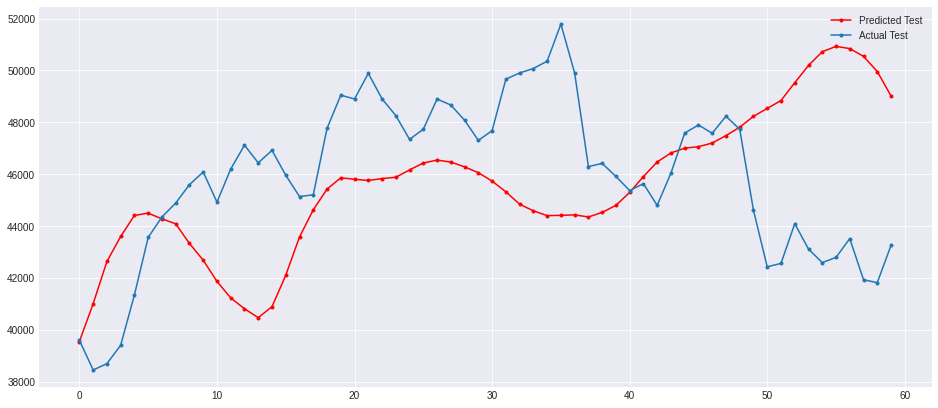

In [280]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_tlog.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_tlog.inverse_transform(testY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_test_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(test_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

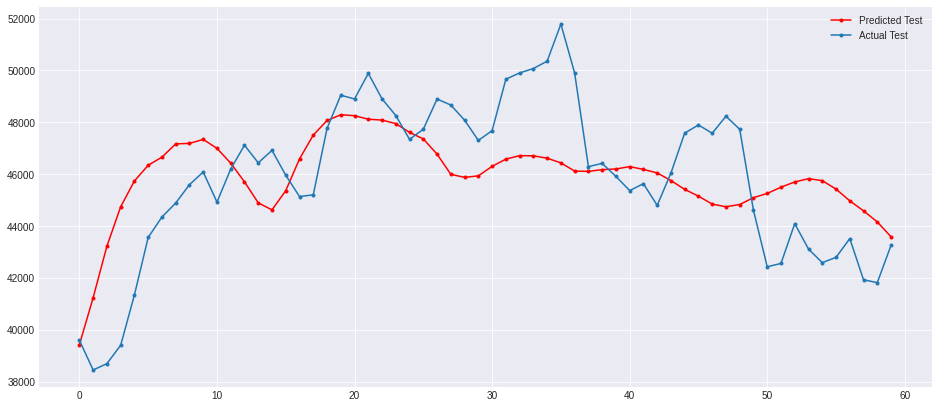

In [177]:
plt.figure(figsize=(16,7))

# log
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_tlog.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_tlog.inverse_transform(testY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_test_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(test_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
# predicted_btc_price_test_data = scaler_t.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
# test_actual = scaler_t.inverse_transform(testY.reshape(-1, 1))

# plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
# plt.plot(test_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

#test train

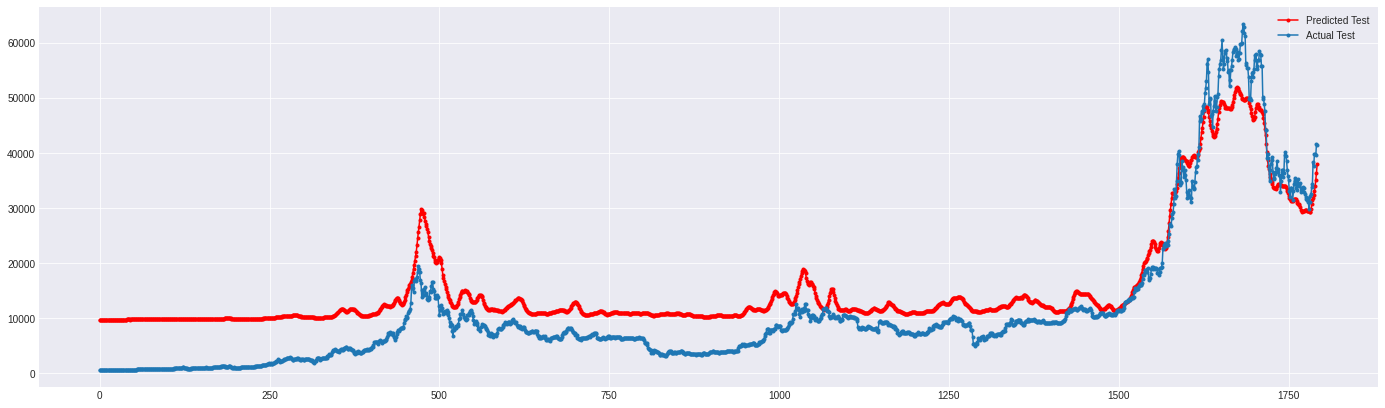

In [281]:
plt.figure(figsize=(24,7))

# log
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_tlog.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
train_actual = scaler_tlog.inverse_transform(trainY.reshape(-1, 1))

plt.plot(np.exp(predicted_btc_price_train_data), 'r', marker='.', label='Predicted Test')
plt.plot(np.exp(train_actual), marker='.', label='Actual Test')

# # manoal
# predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
# predicted_btc_price_train_data = scaler_t.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
# train_actual = scaler_t.inverse_transform(trainY.reshape(-1, 1))

# plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Test')
# plt.plot(train_actual, marker='.', label='Actual Test')


plt.legend()
plt.show()

# score

## log

In [179]:
rmse_lstm_test = math.sqrt(mean_squared_error(np.exp(test_actual), np.exp(predicted_btc_price_test_data)))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2363.389


In [181]:
rmse_lstm_train = math.sqrt(mean_squared_error(np.exp(train_actual), np.exp(predicted_btc_price_train_data)))

print('Train RMSE: %.3f' % rmse_lstm_train)


Train RMSE: 1764.024


## manoal

In [152]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)


Test RMSE: 2951.213


In [153]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_btc_price_train_data))

print('Train RMSE: %.3f' % rmse_lstm_train)


Test RMSE: 1503.741


# future

###### genertor

In [282]:
look_b.tail(7)

,close_log,close,diff7,diff30,diff60,ema20,ema50,ema100,ema200,ema300,mom10,mom60,target_log
date,,,,,,,,,,,,,
2021-09-23,1.562932,2.028560,-1.837446,-2.298415,4.330179,2.157810,2.110529,2.011499,1.879378,1.682299,-0.385526,3.522516,1.543573
2021-09-24,1.543573,1.965363,-2.133014,-2.444575,2.096203,2.139482,2.104836,2.010586,1.880234,1.684179,-1.216863,1.685844,1.533048
2021-09-25,1.533048,1.930052,-2.678997,-2.273643,2.134553,2.119536,2.097982,2.008991,1.880729,1.685813,-1.996350,1.717374,1.537143
2021-09-26,1.537143,1.943633,-2.353598,-2.357625,1.234174,2.102784,2.091929,2.007697,1.881355,1.687526,-2.035304,0.977124,1.551598
2021-09-27,1.551598,1.990851,-0.604755,-2.556726,1.569323,2.092123,2.087965,2.007363,1.882445,1.689542,-1.645042,1.252667,1.519586
2021-09-28,1.519586,1.886941,-0.333484,-3.176013,0.946807,2.072582,2.080082,2.004979,1.882490,1.690853,-2.487361,0.740864,1.517311
2021-09-29,1.517311,1.879744,-0.441779,-2.960064,-0.017275,2.054217,2.072226,2.002499,1.882462,1.692108,-2.338998,-0.051760,1.546449


In [283]:
# def rsi():
#   return scaler_rsi.transform(np.array(ta.rsi(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=14))[-1].reshape(-1,1)).reshape(-1,1)

def ema20():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=20))[-1].reshape(-1,1))).reshape(-1,1)

def ema50():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=50))[-1].reshape(-1,1))).reshape(-1,1)

def ema100():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=100))[-1].reshape(-1,1))).reshape(-1,1)

def ema200():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=200))[-1].reshape(-1,1))).reshape(-1,1)

def ema300():
  return scaler_t.transform(np.array(np.array(ta.ma("ema", pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=300))[-1].reshape(-1,1))).reshape(-1,1)


def mom10():
  return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=10))[-1].reshape(-1,1))).reshape(-1,1)

# def mom30():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=30))[-1].reshape(-1,1))).reshape(-1,1)

# def mom60():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=60))[-1].reshape(-1,1))).reshape(-1,1)

# def mom90():
#   return scaler_mom.transform(np.array(np.array(ta.mom(pd.Series(data=np.exp(scaler_tlog.inverse_transform(np.array(c_log).reshape(-1,1))).reshape(-1)),length=90))[-1].reshape(-1,1))).reshape(-1,1)


# def diff1_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff7_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-7].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff30_log(): # target log
#   d_old = scaler_tlog.inverse_transform(np.array(c_log)[-30].reshape(-1,1))
#   d_new = scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)).reshape(-1,1)
#   d = scaler_diff_log.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

# def diff1(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-1].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff7(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-8].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

# def diff20(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-21].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d

def diff30(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-31].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

def diff60(): # target log
  d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-61].reshape(-1,1)))
  d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
  d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
  return d

#   def diff90(): # target log
#   d_old = np.exp(scaler_tlog.inverse_transform(np.array(c_log)[-91].reshape(-1,1)))
#   d_new = np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1))).reshape(-1,1)
#   d = scaler_diff.transform(np.array(d_new - d_old).reshape(-1,1))
#   return d


def close():
  return scaler_t.transform(np.array(np.exp(scaler_tlog.inverse_transform(np.array(per).reshape(-1,1)))).reshape(-1,1))

###### many to one

In [284]:
from collections import deque

maxlen = 800
c_log = deque(maxlen=maxlen)

for i in range(-maxlen,0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  c_log.append(look_b['close_log'].values[i])


SEQ_LEN=len(testX[-1])
prev_days = deque(maxlen=SEQ_LEN)

for i in range(-len(testX[-1]),0,1):
  # prev_days.append(scaler.transform(test_actual[i].reshape(-1,1)))
  prev_days.append(testX[-1][i])

In [285]:
y_p_ = []
future_len = 500
for i in range(future_len):
  x__ = np.array(prev_days).reshape(-1,len(np.array(prev_days)[-1])).astype(np.float32)

  per = model_from_saved_checkpoint.predict(np.array([x__,x__]))[0].reshape(-1,1)

  Close = close()
  # Rsi = rsi()
  Mom10 = mom10()
  # Mom30 = mom30()
  # Mom60 = mom60()
  # Mom90 = mom90()
  # Diff1_log = diff1_log()
  # Diff7_log = diff7_log()
  # Diff30_log = diff30_log()
  # Diff1 = diff1()
  Diff7 = diff7()
  # Diff20 = diff20()
  Diff30 = diff30()
  Diff60 = diff60()
  # Diff90 = diff90()
  Ema20 = ema20()
  Ema50 = ema50()
  Ema100 = ema100()
  Ema200 = ema200()
  Ema300 = ema300()

  prev_days.append([per.reshape(-1,1), Close, Diff7, Diff30, Diff60, Ema20, Ema50, Ema100, Ema200, Ema300, Mom10]) # Diff30, Diff60, Diff90, Mom30, Mom60, Mom90]) # , Diff1_log, Diff7_log, Diff30_log, Diff1, Diff7, Rsi,
  c_log.append(np.array(per).reshape(-1,1))
  y_p_.append(per.reshape(-1,1))


In [286]:
# log
y_p_ = scaler_tlog.inverse_transform(np.array(y_p_).reshape(-1, 1))
# manoal
# y_p_ = scaler_t.inverse_transform(np.array(y_p_).reshape(-1, 1))

###### plot future

In [287]:
future_actual = scaler_tlog.inverse_transform(futureY.reshape(-1, 1))
actual = np.concatenate((train_actual,test_actual,future_actual))
predicted_btc_price = np.concatenate((predicted_btc_price_train_data, predicted_btc_price_test_data, np.array(y_p_).reshape(-1,1)), axis=0)

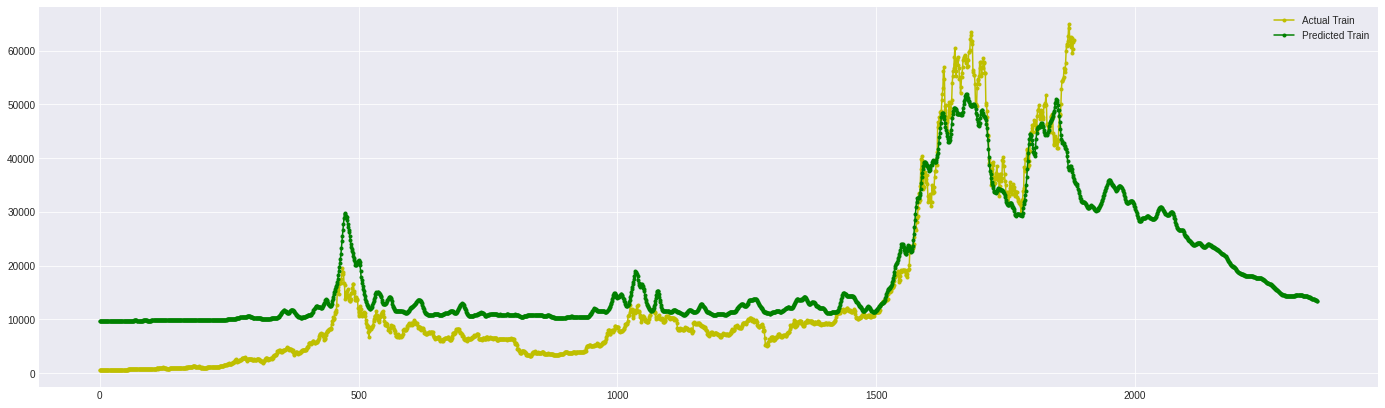

In [288]:
plt.figure(figsize=(24,7))

# log
plt.plot(np.exp(actual),'y', marker='.', label='Actual Train')
plt.plot(np.exp(predicted_btc_price), 'g', marker='.', label='Predicted Train')
# manoal
# plt.plot(actual,'y', marker='.', label='Actual Train')
# plt.plot(predicted_btc_price, 'g', marker='.', label='Predicted Train')


plt.legend()
plt.show()